In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

shape of moons:  (10000, 2)


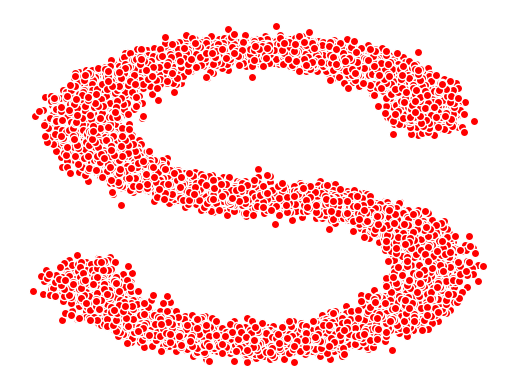

In [2]:
s_curve, _= make_s_curve(10 ** 4, noise=0.1)
s_curve = s_curve[:, [0,2]] / 10.0
print("shape of moons: ", np.shape(s_curve))
data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data, color='red', edgecolor='white')
ax.axis('off')
dataset = torch.Tensor(s_curve).float()

# 超参数的值

In [3]:
num_steps = 100

betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape

print(betas.shape)


torch.Size([100])


# 确定扩散过程任意时刻的采样值

In [4]:
def q_x(x_0, t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    
    return (alphas_t * x_0 + alphas_1_m_t * noise)

# 给原始数据加噪100步后的结果

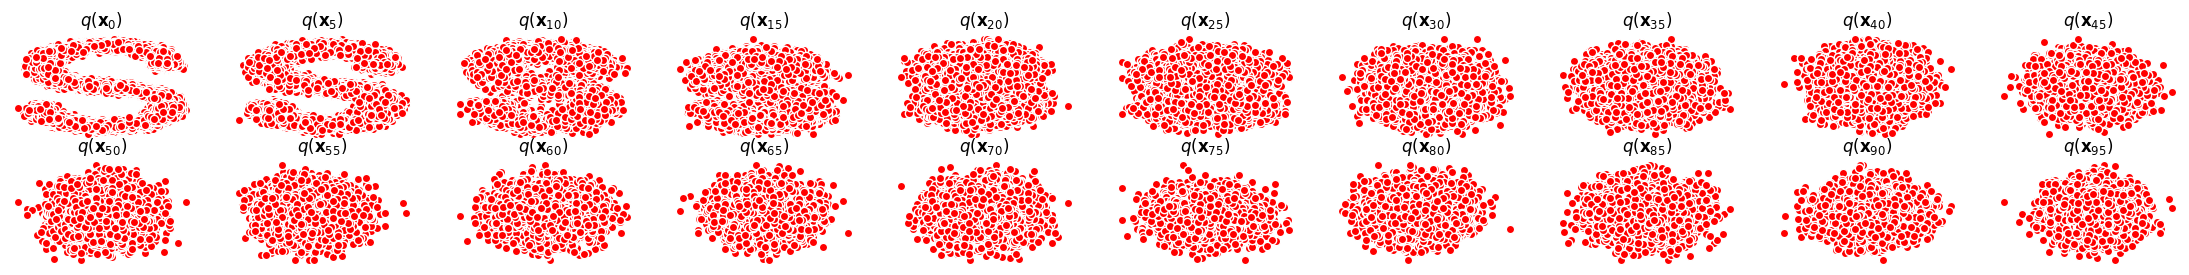

In [5]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='blue')

for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, torch.tensor([i*num_steps//num_shows]))
    axs[j, k].scatter(q_i[:,0], q_i[:, 1], color='red', edgecolor='white')
    axs[j, k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

In [6]:
import torch.nn as nn

class MLPDiffusion(nn.Module):
    
    def __init__(self, n_steps, num_uints=128):
        super(MLPDiffusion, self).__init__()
        self.linears = nn.ModuleList(
        [
            nn.Linear(2, num_uints),
            nn.ReLU(),
            nn.Linear(num_uints, num_uints),
            nn.ReLU(),
            nn.Linear(num_uints, num_uints),
            nn.ReLU(),
            nn.Linear(num_uints, 2),
        ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_uints),
                nn.Embedding(n_steps, num_uints),
                nn.Embedding(n_steps, num_uints),
            ]
        )
    
    def forward(self, x_0, t):
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
        
        x = self.linears[-1](x)
        return x

In [7]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    
    batch_size = x_0.shape[0]
    
    t = torch.randint(0, n_steps, size=(batch_size // 2,))
    t = torch.cat([t, n_steps-1-t], dim=0)
    t = t.unsqueeze(-1)
    
    a = alphas_bar_sqrt[t]
    
    am1 = one_minus_alphas_bar_sqrt[t]
    
    e = torch.randn_like(x_0)
    
    x = x_0 * a + e * am1
    
    output = model(x, t.squeeze(-1))
    return (e - output).square().mean()

In [8]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x,i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t * z
    return (sample)

In [11]:
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        
        fig,axs = plt.subplots(1, 10, figsize=(28, 3))
        
        for i in range(1, 11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white')
            axs[-1].set_axis_off()
            axs[-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([1

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5120000 bytes.